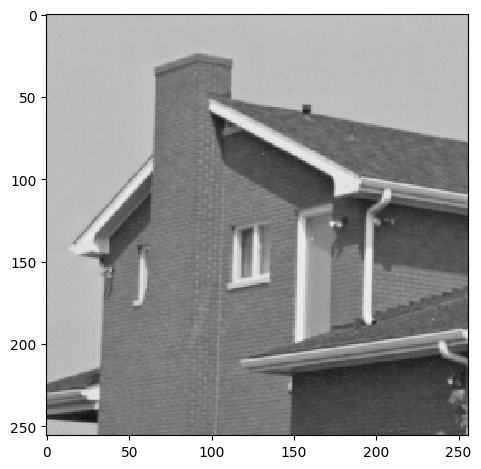

Time taken by NumPy-based detector: 0.1292 seconds


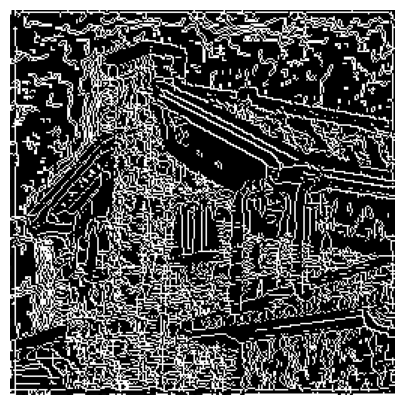

Time taken by CuPy-based detector: 0.0177 seconds


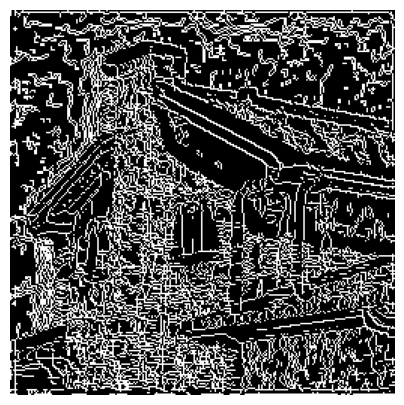

In [5]:
import numpy as np
import cupy as cp
import time
from scipy import ndimage
import matplotlib.pyplot as plt
import skimage.io
from cupyx.scipy.ndimage import convolve
import skimage
import cv2
import cupyx
from cupyx import scipy
from scipy.ndimage import convolve as convolveNumpy
from cupyx.scipy.ndimage import gaussian_filter
from skimage import io

imgs = []

url = "http://sipi.usc.edu/database/download.php?vol=misc&img=4.1.05"
image = skimage.io.imread(url)
image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
imgs.append(image)

io.imshow(image)
io.show()

"""url = "http://sipi.usc.edu/database/download.php?vol=misc&img=4.1.04"
image = skimage.io.imread(url)
image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
imgs.append(image)"""

def visualize(imgs, cmap='gray'):
    """
    Display images for visualization.
    """
    n = len(imgs)
    if n == 1:
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.imshow(imgs[0], cmap=cmap)
        ax.axis('off')
    else:
        fig, axes = plt.subplots(1, n, figsize=(15, 15))
        for i, img in enumerate(imgs):
            ax = axes[i]
            ax.imshow(img, cmap=cmap)
            ax.axis('off')
    plt.show()


# Convert dummy images to CuPy arrays
imgs_cp = [cp.array(img) for img in imgs]


# NumPy-based cannyEdgeDetector
class cannyEdgeDetector:
    def __init__(self, imgs, sigma=1, kernel_size=5, weak_pixel=75, strong_pixel=255, lowthreshold=0.05, highthreshold=0.15):
        self.imgs = imgs
        self.imgs_final = []
        self.img_smoothed = None
        self.gradientMat = None
        self.thetaMat = None
        self.nonMaxImg = None
        self.thresholdImg = None
        self.weak_pixel = weak_pixel
        self.strong_pixel = strong_pixel
        self.sigma = sigma
        self.kernel_size = kernel_size
        self.lowThreshold = lowthreshold
        self.highThreshold = highthreshold

    def gaussian_kernel(self, size, sigma=1):
        """
        Generate a Gaussian kernel to create a filter for blurring the image.
        Parameters are size of the kernel and sigma.
        """
        size = int(size) // 2
        x, y = np.mgrid[-size:size+1, -size:size+1]
        normal = 1 / (2.0 * np.pi * sigma**2)
        g = np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
        g /= np.sum(g)
        return g.astype(np.float32)

    def gaussian_smooth(self, img):
        """
        Smooth the image using the Gaussian kernel to reduce noise and blur the edges.
        Parameters are the input image to be smoothed and function returns smoothed image.
        """
        kernel = self.gaussian_kernel(self.kernel_size, self.sigma)
        smoothed_image = convolveNumpy(img, kernel, mode='constant')
        return smoothed_image

    def sobel_filters(self, img):
        """
        Apply Sobel filters to compute the gradient magnitude and direction of edges in the image.
        Sobel filters approximate the gradient of the image intensity function.
        """
        Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
        Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

        Ix = ndimage.convolve(img, Kx)
        Iy = ndimage.convolve(img, Ky)

        G = np.hypot(Ix, Iy)
        G = G / G.max() * 255
        theta = np.arctan2(Iy, Ix)
        return G, theta

    def non_max_suppression(self, img, D):
        """
        Perform non-maximum suppression to thin out edges by preserving only local maxima.
        All non-maximum pixels, pixels that are not the maximum in their local neighborhood, are suppresed.
        Parameters are gradient magnitude image(img) and gradient direction image (D).
        """
        angle = D * 180. / np.pi
        angle[angle < 0] += 180

        Z = np.zeros_like(img, dtype=np.int32)

        # Define masks and shifts for each direction (0, 45, 90, 135 degrees)
        mask_0 = ((angle >= 0) & (angle < 22.5)) | ((angle >= 157.5) & (angle <= 180))
        mask_45 = (angle >= 22.5) & (angle < 67.5)
        mask_90 = (angle >= 67.5) & (angle < 112.5)
        mask_135 = (angle >= 112.5) & (angle < 157.5)

        q_0 = np.roll(img, -1, axis=1)  # Right
        r_0 = np.roll(img, 1, axis=1)   # Left
        Z = np.where((img >= q_0) & (img >= r_0) & mask_0, img, Z)

        q_45 = np.roll(img, shift=(1, -1), axis=(0, 1))  # Bottom-left
        r_45 = np.roll(img, shift=(-1, 1), axis=(0, 1))  # Top-right
        Z = np.where((img >= q_45) & (img >= r_45) & mask_45, img, Z)

        q_90 = np.roll(img, -1, axis=0)  # Down
        r_90 = np.roll(img, 1, axis=0)   # Up
        Z = np.where((img >= q_90) & (img >= r_90) & mask_90, img, Z)

        q_135 = np.roll(img, shift=(-1, -1), axis=(0, 1))  # Top-left
        r_135 = np.roll(img, shift=(1, 1), axis=(0, 1))    # Bottom-right
        Z = np.where((img >= q_135) & (img >= r_135) & mask_135, img, Z)

        return Z


    def threshold(self, img):
        """
        Apply double thresholding to classify edge pixels into strong, weak, or non-edge pixels based on their intensity values.
        This helps in distinguishing true edges from noise and weak edge candidates.
        Image with pixels classified as strong, weak, or non-edge pixels is returned.
        """
        highThreshold = img.max() * self.highThreshold
        lowThreshold = highThreshold * self.lowThreshold

        M, N = img.shape
        res = np.zeros((M,N), dtype=np.int32)

        weak = np.int32(self.weak_pixel)
        strong = np.int32(self.strong_pixel)

        strong_i, strong_j = np.where(img >= highThreshold)
        weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

        res[strong_i, strong_j] = strong
        res[weak_i, weak_j] = weak

        return res

    def hysteresis(self, img):
        """
        Apply hysteresis thresholding to finalize the edge detection process by connecting weak edges to strong edges.
        This helps in preserving continuous edges while eliminating isolated weak edge pixels.
        """
        M, N = img.shape
        weak = self.weak_pixel
        strong = self.strong_pixel

        for i in range(1, M-1):
            for j in range(1, N-1):
                if (img[i, j] == weak):
                    try:
                        if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                            or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                            or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                            img[i, j] = strong
                        else:
                            img[i, j] = 0
                    except IndexError:
                        pass

        return img

    def detect(self):
        """
        Detect edges in the input images using the Canny edge detection algorithm.
        This involves applying Gaussian smoothing, Sobel filtering, non-maximum suppression,
        double thresholding, and hysteresis thresholding.
        """
        imgs_final = []
        for img in self.imgs:
            self.img_smoothed = self.gaussian_smooth(img)
            self.gradientMat, self.thetaMat = self.sobel_filters(self.img_smoothed)
            self.nonMaxImg = self.non_max_suppression(self.gradientMat, self.thetaMat)
            self.thresholdImg = self.threshold(self.nonMaxImg)
            img_final = self.hysteresis(self.thresholdImg)
            imgs_final.append(img_final)
        return imgs_final
        """imgs_final = []
        for img in self.imgs:
            start_time = time.time()
            self.img_smoothed = self.gaussian_smooth(img)
            end_time = time.time()
            print(f"Gaussian Smoothing (NumPy): {end_time - start_time:.4f} seconds")

            start_time = time.time()
            self.gradientMat, self.thetaMat = self.sobel_filters(self.img_smoothed)
            end_time = time.time()
            print(f"Sobel Filters (NumPy): {end_time - start_time:.4f} seconds")

            start_time = time.time()
            self.nonMaxImg = self.non_max_suppression(self.gradientMat, self.thetaMat)
            end_time = time.time()
            print(f"Non-maximum Suppression (NumPy): {end_time - start_time:.4f} seconds")

            start_time = time.time()
            self.thresholdImg = self.threshold(self.nonMaxImg)
            end_time = time.time()
            print(f"Thresholding (NumPy): {end_time - start_time:.4f} seconds")

            start_time = time.time()
            img_final = self.hysteresis(self.thresholdImg)
            end_time = time.time()
            print(f"Hysteresis (NumPy): {end_time - start_time:.4f} seconds")

            imgs_final.append(img_final)"""


# Benchmark NumPy-based detector
start_time = time.time()
detector_np = cannyEdgeDetector(imgs, sigma=10, kernel_size=6, lowthreshold=0.35, highthreshold=0.55, weak_pixel=12)
imgs_final_np = detector_np.detect()
end_time = time.time()
time_np = end_time - start_time


print(f"Time taken by NumPy-based detector: {time_np:.4f} seconds")
visualize(imgs_final_np, 'gray')



class cupyCannyEdgeDetector:
    """
    Does the same as cannyEdgeDetector, but using cupy.
    """
    def __init__(self, imgs, sigma=1, kernel_size=5, weak_pixel=75, strong_pixel=255, lowthreshold=0.05, highthreshold=0.15):
        self.imgs = imgs
        self.imgs_final = []
        self.weak_pixel = weak_pixel
        self.strong_pixel = strong_pixel
        self.sigma = sigma
        self.kernel_size = kernel_size
        self.lowThreshold = lowthreshold
        self.highThreshold = highthreshold

    def gaussian_kernel(self, size, sigma=1):
        size = int(size) // 2
        x, y = cp.mgrid[-size:size+1, -size:size+1]
        normal = 1 / (2.0 * cp.pi * sigma**2)
        g = cp.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
        g /= cp.sum(g)
        return g.astype(cp.float32)

    def gaussian_smooth(self, img):
        kernel = self.gaussian_kernel(self.kernel_size, self.sigma)
        smoothed_image = convolve(img, kernel, mode='constant')
        return smoothed_image

    def sobel_filters(self, img):
        Kx = cp.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], cp.float32)
        Ky = cp.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], cp.float32)

        Ix = convolve(img, Kx)
        Iy = convolve(img, Ky)

        G = cp.hypot(Ix, Iy)
        G *= 255.0 / G.max()
        theta = cp.arctan2(Iy, Ix)
        return G, theta

    def non_max_suppression(self, img, D):
        angle = D * 180. / cp.pi
        angle = cp.where(angle < 0, angle + 180, angle)

        Z = cp.zeros_like(img, dtype=cp.int32)

        # Define masks and shifts for each direction (0, 45, 90, 135 degrees)
        mask_0 = ((angle >= 0) & (angle < 22.5)) | ((angle >= 157.5) & (angle <= 180))
        mask_45 = (angle >= 22.5) & (angle < 67.5)
        mask_90 = (angle >= 67.5) & (angle < 112.5)
        mask_135 = (angle >= 112.5) & (angle < 157.5)

        q_0 = cp.roll(img, -1, axis=1)  # Right
        r_0 = cp.roll(img, 1, axis=1)   # Left
        Z = cp.where((img >= q_0) & (img >= r_0) & mask_0, img, Z)

        q_45 = cp.roll(img, shift=(1, -1), axis=(0, 1))  # Bottom-left
        r_45 = cp.roll(img, shift=(-1, 1), axis=(0, 1))  # Top-right
        Z = cp.where((img >= q_45) & (img >= r_45) & mask_45, img, Z)

        q_90 = cp.roll(img, -1, axis=0)  # Down
        r_90 = cp.roll(img, 1, axis=0)   # Up
        Z = cp.where((img >= q_90) & (img >= r_90) & mask_90, img, Z)

        q_135 = cp.roll(img, shift=(-1, -1), axis=(0, 1))  # Top-left
        r_135 = cp.roll(img, shift=(1, 1), axis=(0, 1))    # Bottom-right
        Z = cp.where((img >= q_135) & (img >= r_135) & mask_135, img, Z)

        return Z

    def threshold(self, img):
        highThreshold = img.max() * self.highThreshold
        lowThreshold = highThreshold * self.lowThreshold

        res = cp.zeros_like(img, dtype=cp.int32)

        strong_indices = img >= highThreshold
        weak_indices = (img <= highThreshold) & (img >= lowThreshold)

        res = cp.where(strong_indices, self.strong_pixel, res)
        res = cp.where(weak_indices, self.weak_pixel, res)

        return res
    def hysteresis(self, img):
        M, N = img.shape
        weak_pixel = self.weak_pixel
        strong_pixel = self.strong_pixel

        kernel = cp.array([[1, 1, 1],
                          [1, 0, 1],
                          [1, 1, 1]])

        dilated = cp.maximum(cp.maximum(cp.roll(img, 1, axis=0), cp.roll(img, -1, axis=0)),
                            cp.maximum(cp.roll(img, 1, axis=1), cp.roll(img, -1, axis=1)))

        img[(img == weak_pixel) & (dilated == strong_pixel)] = strong_pixel
        img[img == weak_pixel] = 0

        return img

    def detect(self):
        imgs_final = []
        imgs_cp = [cp.array(img) for img in self.imgs]
        for img in imgs_cp:
            img_smoothed = self.gaussian_smooth(img)
            gradientMat, thetaMat = self.sobel_filters(img_smoothed)
            nonMaxImg = self.non_max_suppression(gradientMat, thetaMat)
            thresholdImg = self.threshold(nonMaxImg)
            img_final = self.hysteresis(thresholdImg)
            imgs_final.append(img_final)
        return imgs_final
        """imgs_final = []
        for img in self.imgs:
            start_time = time.time()
            img_smoothed = self.gaussian_smooth(img)
            end_time = time.time()
            print(f"Gaussian Smoothing (CuPy): {end_time - start_time:.4f} seconds")

            start_time = time.time()
            gradientMat, thetaMat = self.sobel_filters(img_smoothed)
            end_time = time.time()
            print(f"Sobel Filters (CuPy): {end_time - start_time:.4f} seconds")

            start_time = time.time()
            nonMaxImg = self.non_max_suppression(gradientMat, thetaMat)
            end_time = time.time()
            print(f"Non-maximum Suppression (CuPy): {end_time - start_time:.4f} seconds")

            start_time = time.time()
            thresholdImg = self.threshold(nonMaxImg)
            end_time = time.time()
            print(f"Thresholding (CuPy): {end_time - start_time:.4f} seconds")

            start_time = time.time()
            img_final = self.hysteresis(thresholdImg)
            end_time = time.time()
            print(f"Hysteresis (CuPy): {end_time - start_time:.4f} seconds")

            imgs_final.append(img_final)"""

# Benchmark CuPy-based detector
start_time = time.time()
detector_cp = cupyCannyEdgeDetector(imgs_cp, sigma=10, kernel_size=6, lowthreshold=0.35, highthreshold=0.55, weak_pixel=12)
imgs_final_cp = detector_cp.detect()
end_time = time.time()
time_cp = end_time - start_time

print(f"Time taken by CuPy-based detector: {time_cp:.4f} seconds")
visualize([cp.asnumpy(img) for img in imgs_final_cp], 'gray')

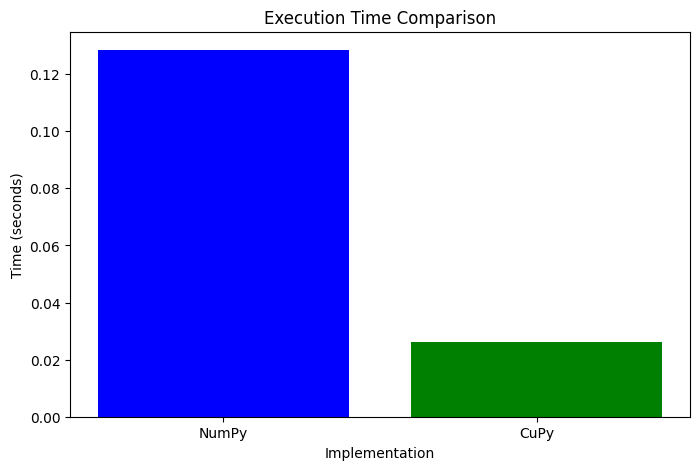

In [3]:
# Execution time comparison
labels = ['NumPy', 'CuPy']
times = [time_np, time_cp]

plt.figure(figsize=(8, 5))
plt.bar(labels, times, color=['blue', 'green'])
plt.title('Execution Time Comparison')
plt.xlabel('Implementation')
plt.ylabel('Time (seconds)')
plt.show()